In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
import os
import matplotlib.pyplot as plt

In [2]:
# Load the DELG model from TensorFlow Hub
model = hub.load("https://tfhub.dev/google/delf/1").signatures['default']

In [3]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = ImageOps.fit(img, (256, 256), Image.LANCZOS)
    img = np.array(img) / 255.0  # Normalize to [0, 1] range
    img = img.astype(np.float32)  # Ensure the image is in float32 format
    #img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

def extract_features(image_path, model):
    img = preprocess_image(image_path)
    result = model(image=tf.convert_to_tensor(img), 
                   score_threshold=tf.constant(100.0, dtype=tf.float32),
                   image_scales=tf.constant([1.0], dtype=tf.float32),
                   max_feature_num=tf.constant(1000, dtype=tf.int32))
    return result['descriptors'].numpy()

In [4]:
def index_database_images(folder_path, model):
    all_descriptors = []
    image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
    for image_path in image_paths:
        descriptors = extract_features(image_path, model)
        all_descriptors.append(descriptors)
    # Average descriptors for each image
    averaged_descriptors = np.array([np.mean(descriptor_set, axis=0) for descriptor_set in all_descriptors])
    print(f"Total descriptors: {averaged_descriptors.shape}")
    print(f"Total image paths: {len(image_paths)}")
    return averaged_descriptors, image_paths

# Index the images in the 'images' folder
descriptors_agg, image_paths = index_database_images('images', model)

# Build the KD-tree
d_tree = cKDTree(descriptors_agg)

Total descriptors: (60, 40)
Total image paths: 60


In [5]:
def extract_landmark_name(image_path):
    filename = os.path.basename(image_path)
    landmark_name = ''.join([i for i in filename if not i.isdigit()]).split('.')[0]
    return landmark_name

def recognize_landmark(query_image_path, model, d_tree, image_paths, top_n=5):
    query_descriptor = extract_features(query_image_path, model)
    query_descriptor = np.mean(query_descriptor, axis=0)  # Average descriptors for the query image
    distances, indices = d_tree.query(query_descriptor, k=top_n)
    nearest_images = [image_paths[idx] for idx in indices]
    landmark_names = [extract_landmark_name(path) for path in nearest_images]
    
    # Calculate confidence scores based on inverse distances
    confidence_scores = 1 / (1 + distances)  # Add 1 to avoid division by zero
    
    return landmark_names, nearest_images, confidence_scores

def plot_images(query_image_path, nearest_images, nearest_landmark_names, confidence_scores, top_n=5):
    fig, axes = plt.subplots(1, top_n+1, figsize=(20, 5))
    
    # Plot query image
    query_img = Image.open(query_image_path)
    query_landmark_name = extract_landmark_name(query_image_path)
    axes[0].imshow(query_img)
    axes[0].set_title(f"Query: {query_landmark_name}", fontsize=8)
    axes[0].axis('off')
    
    # Plot nearest images
    for i, (img_path, landmark_name, score) in enumerate(zip(nearest_images, nearest_landmark_names, confidence_scores), 1):
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"{landmark_name}\nConfidence: {score:.2f}", fontsize=7)
        axes[i].axis('off')
    
    plt.show()

Landmark: duomo


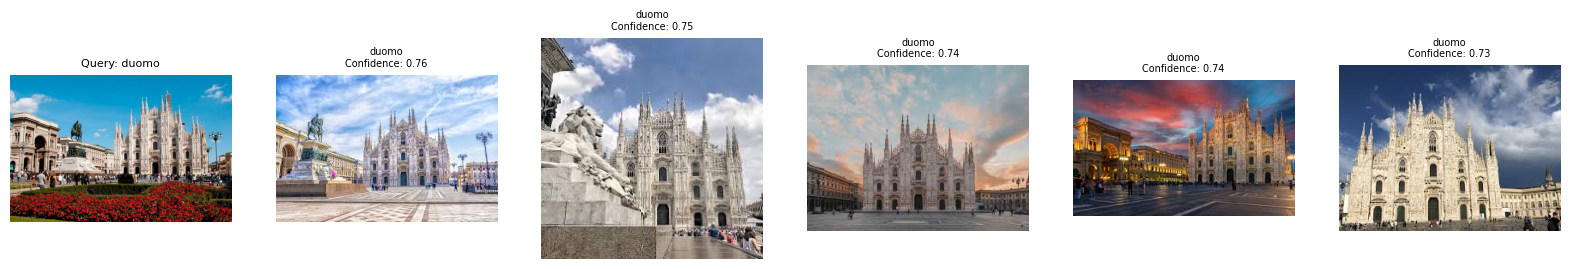

In [6]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# Ask the user to upload an image
root = Tk()
#root.withdraw()  # Hide the root window
initial_dir = os.getcwd()
query_image_path = askopenfilename(initialdir=initial_dir, title='Select an image file')
root.destroy()  # Close the Tkinter window

nearest_landmarks, nearest_images, confidence_scores = recognize_landmark(query_image_path, model, d_tree, image_paths, top_n=5)
print("Landmark:", nearest_landmarks[0])
plot_images(query_image_path, nearest_images, nearest_landmarks, confidence_scores, top_n=5)

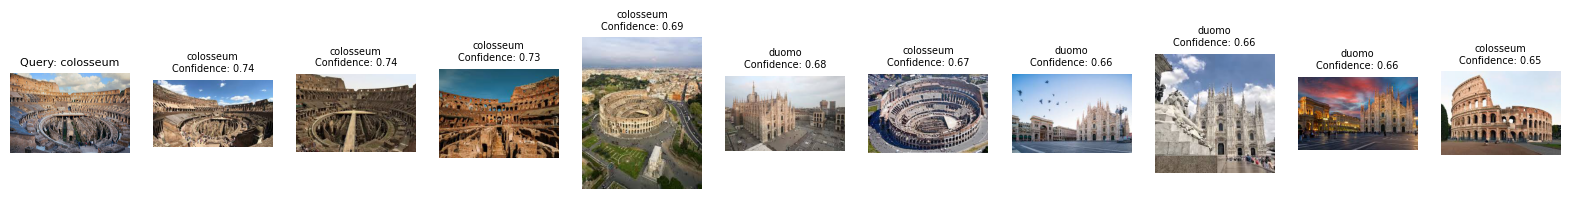

Correct matches for test/colosseum.jpg: 6/10


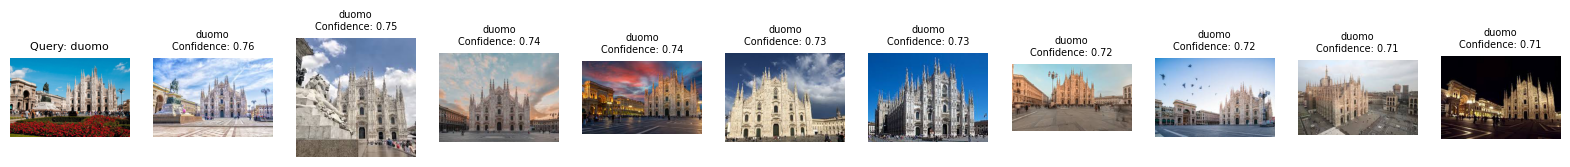

Correct matches for test/duomo.jpg: 10/10


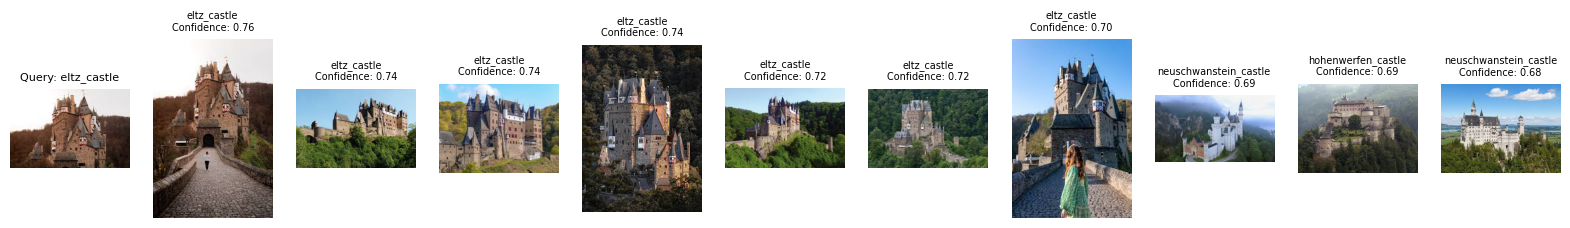

Correct matches for test/eltz_castle.jfif: 7/10


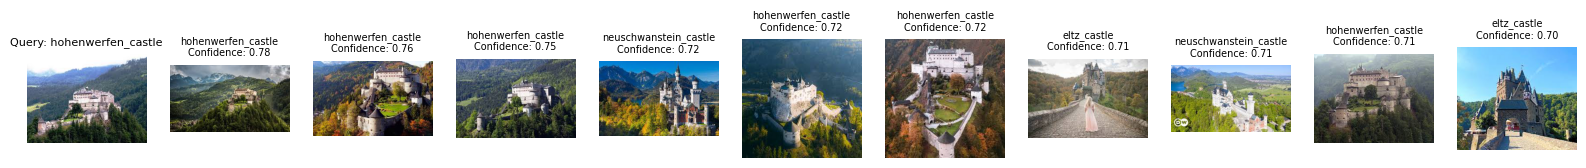

Correct matches for test/hohenwerfen_castle.jfif: 6/10


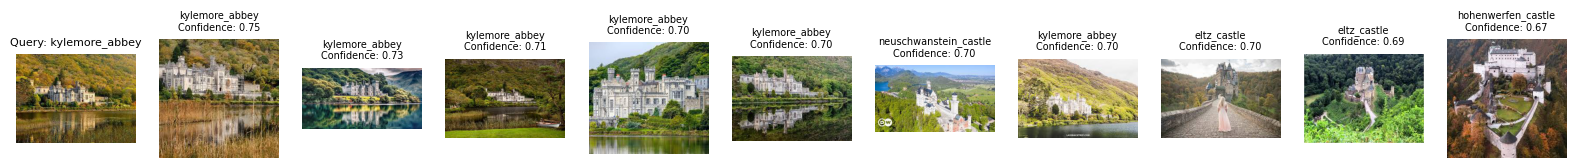

Correct matches for test/kylemore_abbey.jfif: 6/10


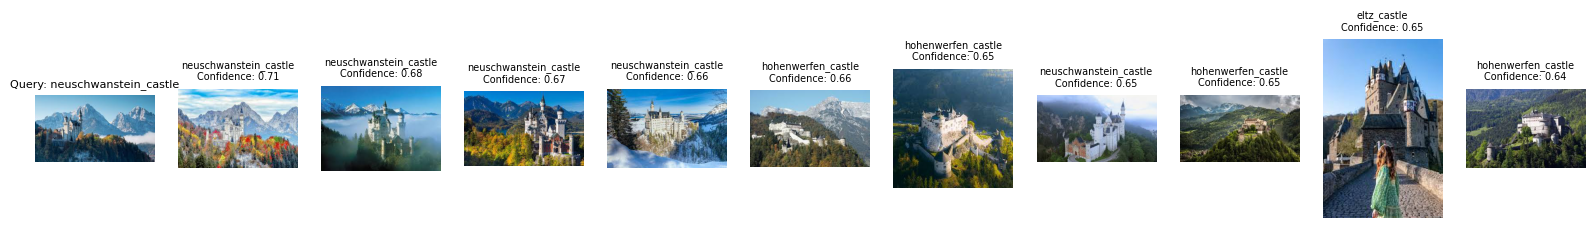

Correct matches for test/neuschwanstein_castle.jfif: 5/10
Total accuracy: 66.67%


In [7]:
query_image_paths = [os.path.join("test/", fname) for fname in os.listdir("test/")]

total_correct = 0
total_images = len(query_image_paths)
top_n = 10
for query_image_path in query_image_paths:
    nearest_landmarks, nearest_images, confidence_scores = recognize_landmark(query_image_path, model, d_tree, image_paths, top_n=top_n)
   
    query_prefix = os.path.basename(query_image_path).split('.')[0]

    correct_matches = 0
    for nearest_landmark in nearest_landmarks:
        match_prefix = ''.join([c for c in nearest_landmark if not c.isdigit()]).split('.')[0]
        if match_prefix == query_prefix:
            correct_matches += 1

    total_correct += correct_matches
    plot_images(query_image_path, nearest_images, nearest_landmarks, confidence_scores, top_n=top_n)
    print(f'Correct matches for {query_image_path}: {correct_matches}/{top_n}')

accuracy = total_correct / (total_images * top_n)
print(f'Total accuracy: {accuracy * 100:.2f}%')